# Regularized Methods for Regression
## Agenda
- Recap of linear regression. 
- Capturing nonlinear relationships in linear models.  
- Review scikit-learn pipelines and training/test splits.  
- Variance/bias and over-fitting.  
- Feature selection methods.  
- Regularization methods and gradient descent.  

# Refresher: Ordinary Least Squares Regression

$\hat\beta = (X^TX)^{-1}X^{T}y$

> Which can be implemented strictly with linear algebra:

```python
betas = inv(mat.transpose().dot(mat)).dot(mat.transpose()).dot(y)
```

> Depending on the implementation, the library may use that method to find the coefficients, or it could use an optimization solver. If you need to know exactly how it is being estimated, it is best to review the documentation.

### Goal - Minimize the mean-squared error
Residuals will be positive and negative, need to penalize negative and positive equally.

Sum of errors: $\epsilon_{1} + \epsilon_{2} + \dots + \epsilon_{n}$  
RSS: $\epsilon_{1}^2 + \epsilon_{2}^2 + \dots + \epsilon_{n}^2$  
MSE: $\frac{1}{N}\sum{\epsilon_{i}^2}$

# Multiple Regression
Instead of an $mx1$ input matrix, we'll have $m \space x \space n$.

### $y = w_{0} + w_{1}x_{1} + \dots + w_{m}x_{m} = \sum{w_{i}x_{i}}=w^{T}x$

<img src='files/diagrams/esl-3-1.png' style="width: 200 px;">

[Introduction to Statistical Learning Figure 3.1](https://www.statlearning.com)

## Back to the Boston Housing Data
Documentation available with:
```python
print(load_boston()['DESCR'])
```

Attribute Information (in order):
- CRIM     per capita crime rate by town
- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS    proportion of non-retail business acres per town
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX      nitric oxides concentration (parts per 10 million)
- RM       average number of rooms per dwelling
- AGE      proportion of owner-occupied units built prior to 1940
- DIS      weighted distances to five Boston employment centres
- RAD      index of accessibility to radial highways
- TAX      full-value property-tax rate per 10,000 dollars  
- PTRATIO  pupil-teacher ratio by town  
- B        1000(Bk - 0.63)^2 where Bk is the proportion of black people by town  
- LSTAT    % lower status of the population  
- MEDV     Median value of owner-occupied homes in 1000's

#### Disclaimer on this data (will generate a warning in scikit-learn $\geq$ 1.0 :
> Warning The Boston housing prices dataset has an ethical problem: the authors of this dataset engineered a non-invertible variable “B” assuming that racial self-segregation had a positive impact on house prices. Furthermore the goal of the research that led to the creation of this dataset was to study the impact of air quality but it did not give adequate demonstration of the validity of this assumption.
<br><br>The scikit-learn maintainers therefore strongly discourage the use of this dataset unless the purpose of the code is to study and educate about ethical issues in data science and machine learning.

#### I made this example prior to updating and will remove it later on. In the interim, I will remove 'B' from consideration.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt
%matplotlib inline
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    bostonDf = pd.DataFrame(load_boston()['data'], columns = load_boston().feature_names)
    bostonT = pd.DataFrame(load_boston()['target'], columns=['MEVD'])

bostonDf = pd.concat([bostonDf, bostonT], axis=1)
del bostonDf['B']
bostonDf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEVD
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [2]:
bostonDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEVD     506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


# Data Exploration

In [3]:
bostonDf.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEVD
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


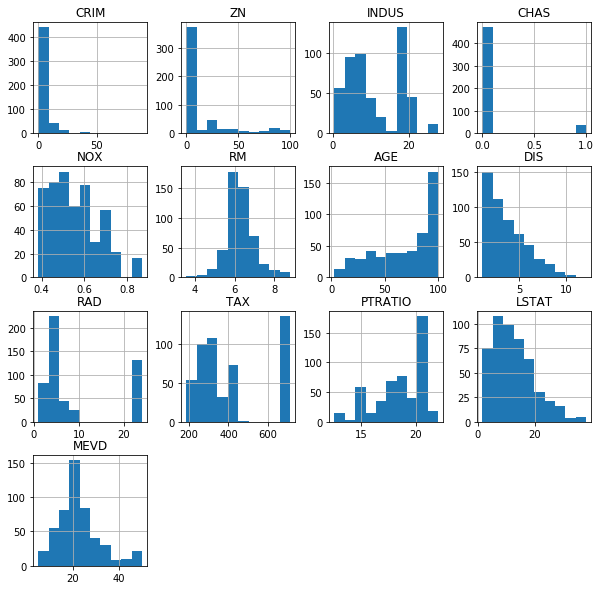

In [4]:
bostonDf.hist(figsize=(10,10))
plt.show()

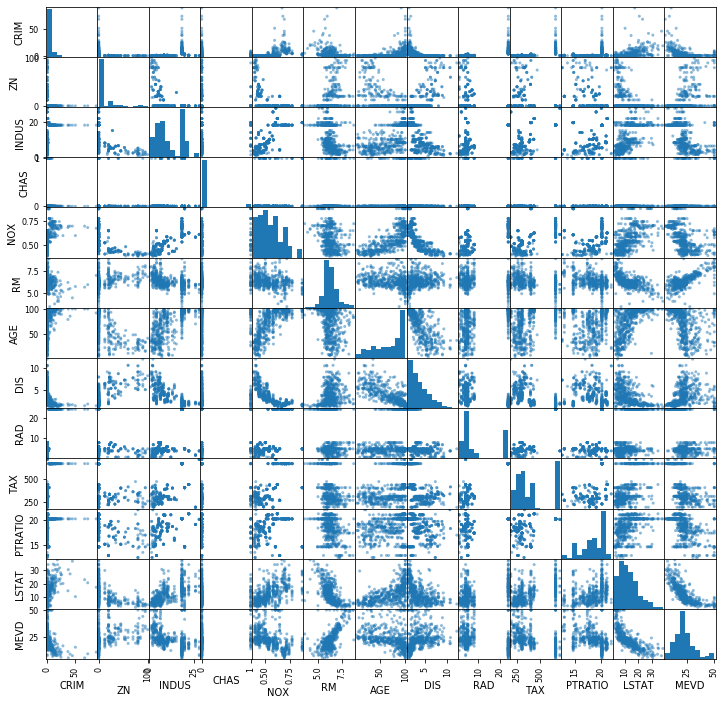

In [5]:
pd.plotting.scatter_matrix(bostonDf, figsize=(12,12))
plt.show()

# Observations
- Potentially some non-linear relationships (e.g., LSTAT (lower status) to MEVD (home values)). 
    - LSTAT.  
    - AGE.  
    - INDUS.  
    - CRIM.  
- Skewness in several variables.  
- Potentially some non-linear multicolinearity (e.g., DIS (distance to centres) and NOX (nitrous concentrations)).  
- CHAS is a dummy variable.    

# Polynomial Features
- Can help capture non-linear relationships.  
- Can easily lead to overfitting, so care is needed when using.  
- We could treat the number of polynomials we add as a hyperparameter.

<img src='files/diagrams/10_12.png' style="width: 700px;">

[Source: Python Machine Learning 3rd Edition, Raschka](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch10/images/10_12.png)

# Best Practices we talked about last week:
- Fill or impute missing values (none here).  
- Standardize variables.  
- Dummies for categorical w/ one category dropped (none here).  
- Splitting of training and test data.  

# Separate Training and Test Data
>Pretend the test data doesn't exist until we go to evaluate our models.

In [6]:
from sklearn.model_selection import train_test_split

featureNames = bostonDf.columns[:-1]
X_training, X_test, y_training, y_test = train_test_split(bostonDf[featureNames], bostonDf['MEVD'],
                                                             test_size=0.20,
                                                          random_state = 50
                                                            )

print(f'Training samples: {X_training.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')

Training samples: 404
Test samples: 102


# Create Feature Processing Pipeline

- Add polynomial features for LSTAT and scale those variables. 
- Scale all other numerical variables.  

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

polys = ['LSTAT', 'AGE', 'INDUS', 'CRIM']
non_polys = ['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD','TAX', 'PTRATIO']

poly_pipeline = Pipeline([('add_polynomials', PolynomialFeatures(3, include_bias=False)),
                           ('standardize_poly', StandardScaler())
                        ])

processing_pipeline = ColumnTransformer(transformers=[('poly_processing', poly_pipeline, polys),
                                ('nonpoly_scaling', StandardScaler(), non_polys)
                               ])

print(processing_pipeline)

ColumnTransformer(transformers=[('poly_processing',
                                 Pipeline(steps=[('add_polynomials',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False)),
                                                 ('standardize_poly',
                                                  StandardScaler())]),
                                 ['LSTAT', 'AGE', 'INDUS', 'CRIM']),
                                ('nonpoly_scaling', StandardScaler(),
                                 ['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD',
                                  'TAX', 'PTRATIO'])])


# Create modeling Pipeline

In [8]:
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), ('lm', LinearRegression())])
modeling_pipeline.fit(X_training, y_training)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('poly_processing',
                                                  Pipeline(steps=[('add_polynomials',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('standardize_poly',
                                                                   StandardScaler())]),
                                                  ['LSTAT', 'AGE', 'INDUS',
                                                   'CRIM']),
                                                 ('nonpoly_scaling',
                                                  StandardScaler(),
                                                  ['ZN', 'CHAS', 'NOX', 'RM',
                                                   'DIS', 'RAD', 'TAX',
      

# Review Results
## Coefficients
- 3 features generated for each column in the polynomial pipeline LSTAT, AGE, INDUS, CRIM. 
- 8 additional features for the other columns.  

In [9]:
modeling_pipeline['lm'].coef_

array([-2.38769007e+01,  2.64114011e+00, -1.26379064e+01,  2.05728414e+02,
        1.12380094e+01,  2.57692665e+01,  4.31770244e+01, -2.00295195e+02,
       -1.03496580e+01, -1.54343710e+01, -8.26772891e+01,  8.74266707e+00,
       -1.32404017e+02, -2.70007542e+03, -8.75778502e+00,  1.34847359e+01,
        6.80575472e+00, -5.54708229e-01, -2.32259786e+01, -3.98890657e+01,
        2.53340024e+01, -1.56554266e+01,  1.64009691e+02,  1.27798037e+01,
        9.74180468e+00,  1.48015670e+01,  5.01255684e+01,  1.45472952e+01,
        6.05619282e+00, -5.33919174e+01, -3.08948311e+00, -4.11517884e+01,
        2.74724431e+03, -3.70668313e+00,  4.66300162e-01,  1.22200647e-01,
       -2.69965907e+00,  2.23121173e+00, -2.65465765e+00,  3.13958424e+00,
       -2.19855242e+00, -1.40417369e+00])

# Model Performance

### Training Data $R^2$:

In [10]:
modeling_pipeline.score(X_training, y_training)

0.8556106765660163

### Test Data $R^2$:

In [11]:
modeling_pipeline.score(X_test, y_test)

0.7444808897497854

>### Is this overfitting or underfitting?

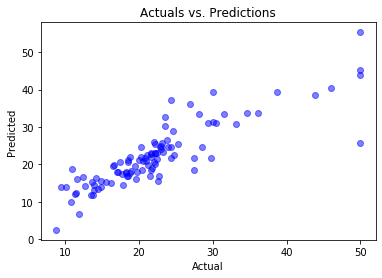

In [12]:
yhat_test = modeling_pipeline.predict(X_test)

plt.plot(y_test, yhat_test, 'bo', alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actuals vs. Predictions')
plt.show()

## Residuals

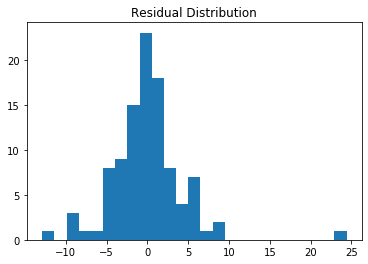

In [13]:
yhat_residuals = y_test - yhat_test

plt.hist(yhat_residuals, bins=25)
plt.title('Residual Distribution')
plt.show()

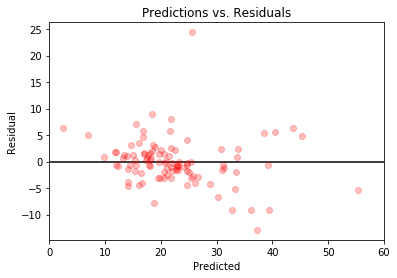

In [14]:
plt.plot(yhat_test, yhat_residuals, 'ro', alpha=0.25)
plt.hlines(0,0,60)
plt.xlim(0,60)
plt.title('Predictions vs. Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

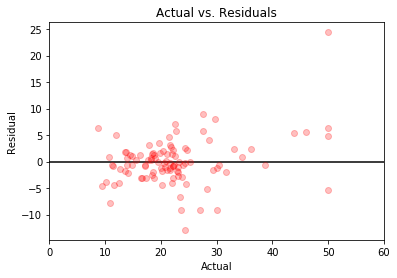

In [15]:
plt.plot(y_test, yhat_residuals, 'ro', alpha=0.25)
plt.hlines(0,0,60)
plt.xlim(0,60)
plt.title('Actual vs. Residuals')
plt.xlabel('Actual')
plt.ylabel('Residual')
plt.show()

# Observations
- If this was a perfect model, the residuals would be 0 for all actual/predicted values.  
- Residuals should look like white noise across all values - seeing some patterns.  
- Some information is leaking into the residuals that the model is capturing.  
    - Could be a feature we don't have access to.  
    - Could be noise in the data.  
    - Could be the underlying relationships are linear.  
    - Insert any number of additional explanations.  
    
There may be some overfitting - the training data fits better than the test data. We can explore other models to see if they are able to reduce the overfitting.

# Bias-variance Tradeoff

<img src='files/diagrams/bullseye.png' style="width: 600px;">

[Image source](http://scott.fortmann-roe.com/docs/BiasVariance.html)

>At its root, dealing with bias and variance is really about dealing with **over- and under-fitting**. Bias is reduced and variance is increased in relation to model complexity. As more and more parameters are added to a model, the complexity of the model rises and variance becomes our primary concern while bias steadily falls
<br><br>Understanding the Bias-Variance Tradeoff, Fortmann-Roe


From Raschka (paraphrased):
>Variance measures the consistency (or variability) of the model prediction. If we retrain the model on different subsets of the training get and observe difference results, we say it is subject to high variance.

>Bias measures how far off the predictions are from the correct values. This will be error that isn't due to differences in the training datasets.

[Bias and variance from Raschka's Evaluation Lecture Notes](https://sebastianraschka.com/pdf/lecture-notes/stat479fs18/08_eval-intro_notes.pdf)


<img src='files/diagrams/high-bias.png' style="width: 600px;">


<img src='files/diagrams/high-variance.png' style="width: 600px;">



# Simple Usually Triumphs Over the Complex
It's a balancing act though. You'll need a minimum level of complexity to capture the relationships in the data.

<img src='files/diagrams/biasvariance.png'>

[Image source](http://scott.fortmann-roe.com/docs/BiasVariance.html)

## Potential Options
- Include less features.  
- Shrinkage methods.  
- Data over models.  

# Low Variance, Forward, and Backward Selection

## [Low Variance](https://scikit-learn.org/stable/modules/feature_selection.html)
>You can automatically omit features with zero-variance (i.e., constants).

In [16]:
from sklearn.feature_selection import VarianceThreshold
X = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]])
print(X)

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]
 [0 1 1]]


In [17]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

### Cautions
- You need to set the variance threshold.  
- Would add a lot of complexity to the search space.  

## [Forward or Backward Selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)

From scikit-learn:
>Forward-SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the n_features_to_select parameter.

>Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set. The direction parameter controls whether forward or backward SFS is used.
<br><br>In general, forward and backward selection do not yield equivalent results. Also, one may be much faster than the other depending on the requested number of selected features: if we have 10 features and ask for 7 selected features, forward selection would need to perform 7 iterations while backward selection would only need to perform 3.

>SFS differs from RFE and SelectFromModel in that it does not require the underlying model to expose a coef_ or feature_importances_ attribute. It may however be slower considering that more models need to be evaluated, compared to the other approaches. For example in backward selection, the iteration going from m features to m - 1 features using k-fold cross-validation requires fitting m * k models, while RFE would require only a single fit, and SelectFromModel always just does a single fit and requires no iterations.

[See a *Comparative Study of Techniques for Large-Scale Feature Selection* for more discussion.](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.4369&rep=rep1&type=pdf)

### Basic Idea
- Start with all the features. 
- Determine the feature provided the least added benefit.    
- Remove the above feature.  
- Continue until reach the desired number of features or hit a threshold.  

### Rational
> Automatically select the most relevant subset of features.  

> Really only necessary if your models don't support regularization.

> Can help with the *Curse of Dimensionality* since it'll generally select a more parsimonious model with dense features.

From Machine Learning with Python, SBS (backward) showed a model with 3 features would have achieved 100% accuracy on the validation data set. See pages 137-139.
<img src='files/diagrams/04_08.png' style='width: 300px;'>

[Image source - Raschka's GitHub; Python for Machine Learning 3rd Edition, Figure 4.8](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch04/images/04_08.png)


- I've never used these in practice - there are other ways to guard against overfitting and selecting a more parsimonious model.  
- Can add a lot of computational overhead.  

[See an example from scikit-learn for code example.](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)

# Regularization
>Helps solve overfitting (high variance) - having too many parameters (i.e., too complex).  

>Also helps with multicolinearity (which we saw) and filtering out noise.  

### Types of regularization:
- $L1$ (lasso - least absolute shrinkage and selection operator): penalizing the sum of $\lvert \beta_{j} \rvert$  
- $L2$ (ridge): penalizing the sum of the $\beta_{j}$'s

# Shrinkage with Ridge Regression ($l_2$ Regularization)
## We can modify our loss function to penalize complexity
Shrinking parameter values to penalize for increased complexity (i.e., parameters with meaningful weights).
>Shrinks, but does not eliminate. Coefficients will be non-zero. Will that help when there any many many features?

## Reduces the influence of parameters that carry less weight

Recall $\hat\beta = (X^TX)^{-1}X^{T}y$  
Goal: $\frac{1}{N}\sum{\epsilon_{i}^2}$

#### We can force parameters to shrink towards zero, effectively reducing their influence by adding a penality to the loss function:
$argmin\frac{1}{N}\sum{\epsilon_{i}^2} + \sum{\lambda\beta_{j}^2}$
- What happens with $\lambda=0$?

New closed form: $\hat\beta = (X^TX+\lambda{I})^{-1}X^{T}y$ 

> Ridge has a unique solution, similar to OLS. You can modify the closed form implementation from last class as an independent proof. scikit-learn's implementation uses various optimization methods to solve the loss optimization problem, so it won't be 100% comparable to OLS with $\alpha=0$, it'll be close though.

## Introduces $\lambda$ - our first (official) hyperparameter!
$\lambda$ controls the amount of the penality, it is bounded between 0 and $\infty$.
>When $\lambda=0$, ridge will provide the same coefficients as OLS, since the $\lambda{I}$ will become zero.

In [18]:
from sklearn.linear_model import Ridge

modeling_pipeline_ridge = Pipeline([('data_processing', processing_pipeline), ('ridge', Ridge(alpha=0))])
modeling_pipeline_ridge.fit(X_training, y_training)
modeling_pipeline_ridge['ridge'].coef_

array([-2.38769007e+01,  2.64114011e+00, -1.26379064e+01,  2.05728414e+02,
        1.12380093e+01,  2.57692665e+01,  4.31770244e+01, -2.00295195e+02,
       -1.03496579e+01, -1.54343710e+01, -8.26772897e+01,  8.74266708e+00,
       -1.32404017e+02, -2.70007542e+03, -8.75778501e+00,  1.34847359e+01,
        6.80575473e+00, -5.54708232e-01, -2.32259786e+01, -3.98890657e+01,
        2.53340024e+01, -1.56554266e+01,  1.64009690e+02,  1.27798037e+01,
        9.74180468e+00,  1.48015669e+01,  5.01255685e+01,  1.45472952e+01,
        6.05619326e+00, -5.33919174e+01, -3.08948312e+00, -4.11517889e+01,
        2.74724432e+03, -3.70668313e+00,  4.66300163e-01,  1.22200647e-01,
       -2.69965907e+00,  2.23121173e+00, -2.65465765e+00,  3.13958424e+00,
       -2.19855242e+00, -1.40417369e+00])

>The non-polynomial features are relatively close.

In [19]:
modeling_pipeline['lm'].coef_

array([-2.38769007e+01,  2.64114011e+00, -1.26379064e+01,  2.05728414e+02,
        1.12380094e+01,  2.57692665e+01,  4.31770244e+01, -2.00295195e+02,
       -1.03496580e+01, -1.54343710e+01, -8.26772891e+01,  8.74266707e+00,
       -1.32404017e+02, -2.70007542e+03, -8.75778502e+00,  1.34847359e+01,
        6.80575472e+00, -5.54708229e-01, -2.32259786e+01, -3.98890657e+01,
        2.53340024e+01, -1.56554266e+01,  1.64009691e+02,  1.27798037e+01,
        9.74180468e+00,  1.48015670e+01,  5.01255684e+01,  1.45472952e+01,
        6.05619282e+00, -5.33919174e+01, -3.08948311e+00, -4.11517884e+01,
        2.74724431e+03, -3.70668313e+00,  4.66300162e-01,  1.22200647e-01,
       -2.69965907e+00,  2.23121173e+00, -2.65465765e+00,  3.13958424e+00,
       -2.19855242e+00, -1.40417369e+00])

# Now to evaluate different $\lambda$ values
>We'll need to evaluate a gradient of $\lambda$ values to determine the best one to use.

In [54]:
from collections import defaultdict
alphas = [0, 1, 2, 5, 10, 50]

ridge_results = defaultdict(dict)

for alph in alphas:
    modeling_pipeline_ridge = Pipeline([('data_processing', processing_pipeline), ('ridge', Ridge(alpha=alph))])
    modeling_pipeline_ridge.fit(X_training, y_training)
    ridge_results['coefficients'][alph] = modeling_pipeline_ridge['ridge'].coef_
    ridge_results['training score'][alph] = modeling_pipeline_ridge.score(X_training, y_training)
    ridge_results['test score'][alph] = modeling_pipeline_ridge.score(X_test, y_test)
    
print('Finished')

Finished


### Changes in Coefficient Values

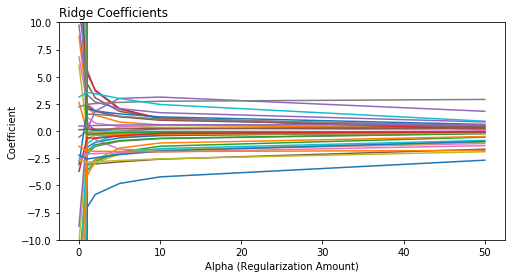

In [61]:
coefficients = pd.DataFrame.from_dict(ridge_results['coefficients'])
coefficients = coefficients.reset_index()
coefficients = coefficients.rename(columns={'index':'coefficient_nbr'})
coefficients = coefficients.melt(id_vars='coefficient_nbr', var_name='alpha', value_name='coefficient')

(
coefficients.pivot_table(index='alpha', columns='coefficient_nbr', values='coefficient')
    .plot(figsize=(8,4),legend=False)
)

plt.title('Ridge Coefficients', loc='left')
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Coefficient')
plt.ylim((-10, 10))
plt.show()

### Changes in $R^2$

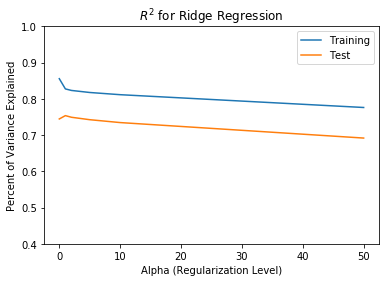

In [62]:
ridge_training_r2 = pd.Series(ridge_results['training score'])
ridge_test_r2 = pd.Series(ridge_results['test score'])

ridge_training_r2.plot()
ridge_test_r2.plot()
plt.title('$R^2$ for Ridge Regression')
plt.legend(['Training','Test'])
plt.xlabel('Alpha (Regularization Level)')
plt.ylabel('Percent of Variance Explained')
plt.ylim(0.4, 1)
plt.show()

# Discussion
> Maybe adding a little regularization helps the score on the test data, but it's not material.

> Is it possible for fit to get better on the training data with Ridge vs. OLS?

# Gradient Descent (GD) Required (Generally) for Lasso
OLS and Ridge regression have unique solutions (even though scikit-learn uses optimization). In order to talk about some of the other variants, we need to talk about an optimization technique called gradient descent.

Gradient descent is an optimization technique that allows us to "learn" what the coefficients should be by iteration and continuous improvment. Traditional statisticans don't love this technique since it's not too far away from guessing a bunch of times until you can't guess much better.  

<img src='files/diagrams/gs.png' style="width: 300px;">

[Image source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.datasciencecentral.com%2Fprofiles%2Fblogs%2Falternatives-to-the-gradient-descent-algorithm&psig=AOvVaw1ki8gWYTrWRy-NKpu7RFgo&ust=1631036623607000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCJiSq6nz6vICFQAAAAAdAAAAABAD)

Gradient descent essentially is looking for the local minimums of loss functions that are differentiable.  

While least-squares does not a closed-form solution, you can also approximate it using gradient descent. Gradient descent will reappear with other algorithms.

GD requires a loss function, which for OLS regression is the sum of squared errors:
$$J(w)=\frac{1}{2}\sum(y^{(i)} - \hat{y}^{(i)})^2$$

This also be used in logistic regression and neural networks.

## Updating weights
All of the weights are set simultaneously.

1. Initialize weights to 0 or small random numbers. 
2. For each training example, $x^{i}$:  
    a. Compute the output value, $\hat{y}$.  
    b. Update the weights.


## OLS Implementation

In [23]:
def gradientDescent(x, y, theta, alpha, m, numIterations):
    thetaHistory = list()
    
    xTrans = x.transpose()
    costList = list()
    
    for i in range(0, numIterations):
        # data x feature weights = y_hat
        hypothesis = np.dot(x, theta)
        # how far we are off
        loss = hypothesis - y 
        # mse
        cost = np.sum(loss ** 2) / (2 * m)
        costList.append(cost)

        # avg gradient per example
        gradient = np.dot(xTrans, loss) / m 

        # update
        theta = theta - alpha * gradient
        thetaHistory.append(theta)
        
    return thetaHistory, costList

## Create training data

In [24]:
data_pipeline = Pipeline([('data_processing', processing_pipeline)])
data_pipeline.fit(X_training)

gs_training_data = data_pipeline.fit_transform(X_training)

## Run the algorithm

In [25]:
import datetime

start_ts = datetime.datetime.now()
betaHistory, costList = gradientDescent(gs_training_data,y_training,
                                        theta=np.zeros(gs_training_data.shape[1]),
                                        alpha=0.01,
                                        m=gs_training_data.shape[0], numIterations=5000)
                                                                 
end_ts = datetime.datetime.now()

print(f'Completed in {end_ts-start_ts}')

Completed in 0:00:01.498239


# Now we can see it "learning"
After each iteration it finds a better value and continues until it reaches our thresholds.

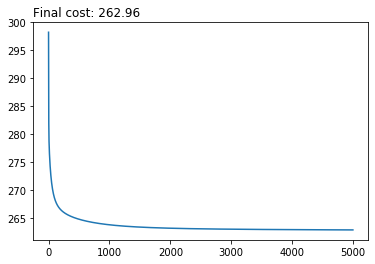

In [26]:
plt.plot(costList)
plt.title(f'Final cost: {costList[-1]:,.2f}', loc='left')
plt.show()

## Show changes in $\beta$ throughout the iterations

In [27]:
from collections import defaultdict
thetas = defaultdict(list)

for i in range(len(betaHistory)):
    for j in range(len(betaHistory[i])):
        thetas[j].append(betaHistory[i][j])

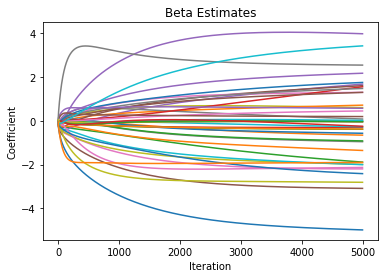

In [28]:
thetasD = pd.DataFrame.from_dict(thetas)
thetasD.plot(legend=False)
plt.title('Beta Estimates')
plt.ylabel('Coefficient')
plt.xlabel('Iteration')
plt.show()

### Predictions

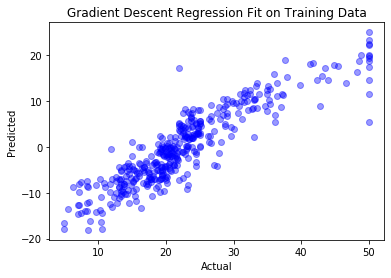

In [29]:
gs_betas = betaHistory[4999]
gs_predictions = np.dot(gs_training_data, gs_betas)

plt.plot(y_training, gs_predictions, 'bo', alpha=0.4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Descent Regression Fit on Training Data')
plt.show()

# Where things can go wrong:
- The learning rate (alpha generally) is really important. If you pick a rate that is too large, you may hop over the minimum and the models will either be very poor or never converge.  
- Other thresholds may take some trial and error.  
- You can get stuck at a local minima and never find the local maxima.  
- You need to know when to stop. It'll keep adjusting coefficients until it reaches an iteration limit or a derivative threshold. Too long and overfitting could occur.

# Lasso Regression ($l_1$ Regularization)
No closed form solution - will need to use optimization techniques regardless.  

$$
J(w)_{lasso}=\sum{(y^{(i)}-\hat{y}^{(i)})^2+\lambda \lvert \lvert w \rvert \rvert_1}
$$

$$
L1:\lambda \lvert \lvert w \rvert \rvert_1 = \lambda \sum{\lvert w_j \rvert}
$$

Could modify the gradient descent with the above, but we'll let sci-kit learn handle it.

## Differences from Ridge

<img src='files/diagrams/ridge-v-lasso.png'>

[Introduction to Statistical Learning, Figure 3.11](https://www.statlearning.com)
>Estimation picture for the lasso (left) and ridge regression (right). Shown are contours of the error and constraint functions. The solid blue areas are the constraint regions $\lvert \beta_1 \rvert \leq t$ and $\beta_{1}^2 + \beta_{2}^2 \leq t^2$, respectivity, while the red ellipses are the contours of the least squares error function.

#### Explanation from Raschka (Python Machine Learning 3rd Edition, Chapter 4, pages 129-131):
> We can think of regularization as adding a penalty term to the cost function to encourage smaller weighs; in other words, we penalize large weights. Thus, by increasing the regularization strength via the regularization parameter, we shrink the weights toward zero and decrease the dependence of our model on the training data.

> The shaded regions of represent the regularization "budget" - the combination of the weights cannot exceed those limits. As the regularization term increases, so does the area of that shaded region.

[See Elements of Statistical Learning Section 3.4 for a more thorough discussion.](https://web.stanford.edu/~hastie/ElemStatLearn/)

### TL:DR - Lasso can create sparse models, Ridge cannot.
Ridge will have non-zero estimates for its $\beta$ values, and lasso can result in some $\beta$ values equal to zero (i.e., sparse).

- Lasso should provide better protection to overfitting than Ridge and OLS.  
- Can also be a technique by itself for feature selection.  

## Lasso on our housing data
$\lambda$ controls the amount of the penality, it is bounded between 1 and $\infty$.

>Again we'll need to evaluate different $\lambda$ values.

In [50]:
from sklearn.linear_model import Lasso
from collections import defaultdict

alphas = [1, 2, 5, 10, 50]

lasso_results = defaultdict(dict)

for alph in alphas:
    modeling_pipeline_lasso = Pipeline([('data_processing', processing_pipeline), ('lasso', Lasso(alpha=alph))])
    modeling_pipeline_lasso.fit(X_training, y_training)
    lasso_results['coefficients'][alph] = modeling_pipeline_lasso['lasso'].coef_
    lasso_results['training score'][alph] = modeling_pipeline_lasso.score(X_training, y_training)
    lasso_results['test score'][alph] = modeling_pipeline_lasso.score(X_test, y_test)
    
print('Finished')

Finished


## Coefficient Values

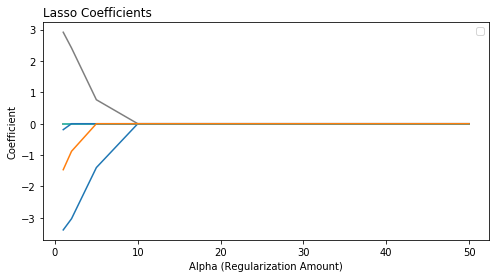

In [63]:
coefficients = pd.DataFrame.from_dict(lasso_results['coefficients'])
coefficients = coefficients.reset_index()
coefficients = coefficients.rename(columns={'index':'coefficient_nbr'})
coefficients = coefficients.melt(id_vars='coefficient_nbr', var_name='alpha', value_name='coefficient')

coefficients.pivot_table(index='alpha', columns='coefficient_nbr', values='coefficient').plot(figsize=(8,4))
plt.title('Lasso Coefficients', loc='left')
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Coefficient')
plt.legend('')
plt.show()

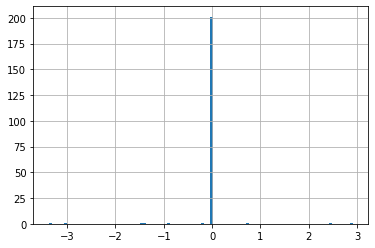

In [64]:
coefficients['coefficient'].hist(bins=100)
plt.show()

### Changes in $R^2$

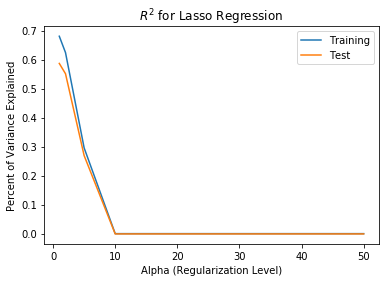

In [65]:
lasso_training_r2 = pd.Series(lasso_results['training score'])
lasso_test_r2 = pd.Series(lasso_results['test score'])

lasso_training_r2.plot()
lasso_test_r2.plot()
plt.title('$R^2$ for Lasso Regression')
plt.legend(['Training','Test'])
plt.xlabel('Alpha (Regularization Level)')
plt.ylabel('Percent of Variance Explained')
plt.show()

# [Elastic Net Regression ($l1$ and $l2$)](https://en.wikipedia.org/wiki/Elastic_net_regularization)

$$
J(w)_{ElasticNet}=\sum{(y^{(i)}-\hat{y}^{(i)})^2+
\lambda_1 \sum{w_j^2} +
\lambda_2 \sum{\lvert w_j \rvert}
}
$$

- Can help with highly correlated variables.  
- Used in Support Vector Machines.  
- At least two (2) hyperparameters now - search space is much larger.

In [34]:
from sklearn.linear_model import ElasticNet
from collections import defaultdict

alphas = [1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]
ratio = [0.1, 0.25, 0.50, 0.75, 0.9]

en_results = defaultdict(dict)
en_results['coefficients'] = defaultdict(dict)
en_results['training score'] = defaultdict(dict)
en_results['test score'] = defaultdict(dict)

for alph in alphas:
    for lr in ratio:
        modeling_pipeline_en = Pipeline([('data_processing', processing_pipeline),
                                         ('en', ElasticNet(alpha=alph, l1_ratio=lr))
                                        ])
        modeling_pipeline_en.fit(X_training, y_training)
        en_results['coefficients'][alph][lr] = modeling_pipeline_en['en'].coef_
        en_results['training score'][alph][lr] = modeling_pipeline_en.score(X_training, y_training)
        en_results['test score'][alph][lr] = modeling_pipeline_en.score(X_test, y_test)
    
print('Finished')

Finished


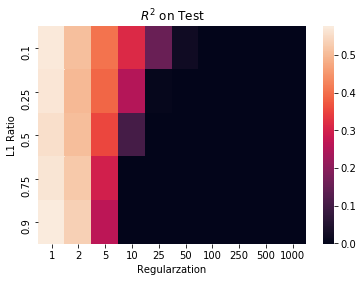

In [35]:
import seaborn as sns

sns.heatmap(pd.DataFrame.from_dict(en_results['test score']))
plt.xlabel('Regularzation')
plt.ylabel('L1 Ratio')
plt.title('$R^2$ on Test')
plt.show()

# Why may have these not have helped?
> Did we check for bias?
> Linear regression by nature isn't exceptionally prone to overfitting.  
> We may have a "favorable" training/test split.

# Readings
- [Andrew Ng on Regularization](https://www.youtube.com/watch?v=NyG-7nRpsW8&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=6)  
- [Great notes from Goker Erdogan](https://github.com/gokererdogan/JaverianaMLCourse/blob/master/Lectures/05.pdf). 
- [Raschka on Regularization Performance](https://sebastianraschka.com/faq/docs/regularized-logistic-regression-performance.html)  
- [Raschka's Linear Regression Notes](http://rasbt.github.io/mlxtend/user_guide/regressor/LinearRegression/)

From Raschka's post:
>Regularization does NOT improve the performance on the data set that the algorithm used to learn the model parameters (feature weights). However, it can improve the generalization performance, i.e., the performance on new, unseen data, which is exactly what we want.